# Amazon Product Reviews Analysis: Unsupervised Learning Approaches
## Final, Unsupervised Algorithms in Machine Learning

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#from gensim import corpora, models
import warnings
warnings.filterwarnings('ignore')

# Amazon Product Reviews Analysis: Unsupervised Learning Approaches

## 1. Introduction and Problem Statement

E-commerce platforms like Amazon generate massive amounts of user-generated content in the form of product reviews. These reviews contain insights about customer preferences, product features, and market trends. However, extracting actionable insights from this unstructured data presents significant challenges due to its volume and complexity.

This project aims to apply various unsupervised learning techniques to analyze Amazon product reviews of electronics to:

1. Discover themes in customer reviews
2. Identify groupings of products based on customer perception
3. Reduce the dimensionality of the feature space to visualize patterns

By analyzing this data, I can help businesses better understand customer preferences and improve products. This project demonstrates the application of multiple unsupervised learning approaches to extract business value from unstructured text data.

This project can be found on Github here: https://github.com/alec-sekelsky/Amazon-review-Unsup-Final

## 2. Data Collection and Description

### Data Source
The dataset used in this analysis is the Amazon Product Reviews dataset collected by Julian McAuley from UC San Diego. This dataset contains product reviews and metadata from Amazon spanning 1996 to 2023. The dataset includes millions of reviews across various product categories.

For this project, I will focus on a subset of the data to make the analysis more manageable while still providing meaningful insights. I'll use the "Electronics" category, which contains a diverse range of products and substantial review content.

The entirety of the electronics subset is around 44 million rows - an amount of data that I am not necessarily needing for this project, I will only use the first 500,000 rows. 

### Dataset Citation
The data was originally collected for research purposes and has been made publicly available for academic use. The dataset is available from: https://amazon-reviews-2023.github.io/

### Data Structure
The dataset contains the following key fields:
- `rating`: Rating of the product (from 1.0 to 5.0).
- `title`: Title of the user review.
- `text`: Text body of the user review.
- `images`: Images that users post after they have received the product. Each image has different sizes (small, medium, large), represented by the small_image_url, medium_image_url, and large_image_url respectively.
- `asin`: ID of the product.
- `parent_asin`: Parent ID of the product. Note: Products with different colors, styles, sizes usually belong to the same parent ID. The “asin” in previous Amazon datasets is actually parent ID. Please use parent ID to find product meta.
- `user_id`: ID of the reviewer
- `timestamp`: Time of the review (unix time)
- `verified_purchase`: User purchase verification
- `helpful_vote`: Helpful votes of the review

### Data Collection Method
Sample of the dataset:

In [4]:
data = pd.read_csv("electronics_3m_subset.csv")
data = data.head(500_000)
data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,[{'small_image_url': 'https://m.media-amazon.c...,B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True
2,5.0,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True


## 3. Exploratory Data Analysis

In [5]:
# Basic dataset information
print(f"Dataset dimensions: {data.shape}")
print("\nData types:")
print(data.dtypes)
print("\nMissing values by column:")
print(data.isnull().sum())

# Display dataset statistics
print("\nBasic statistics for numerical columns:")
print(data.describe())

Dataset dimensions: (500000, 10)

Data types:
rating               float64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
user_id               object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
dtype: object

Missing values by column:
rating                0
title                85
text                 85
images                0
asin                  0
parent_asin           0
user_id               0
timestamp             0
helpful_vote          0
verified_purchase     0
dtype: int64

Basic statistics for numerical columns:
              rating     timestamp   helpful_vote
count  500000.000000  5.000000e+05  500000.000000
mean        4.230672  1.524166e+12       1.431662
std         1.277176  9.931105e+10      27.729206
min         1.000000  8.889274e+11       0.000000
25%         4.000000  1.454768e+12       0.000000
50%         5.000000  1.53550

### 3.1 Ratings Distribution

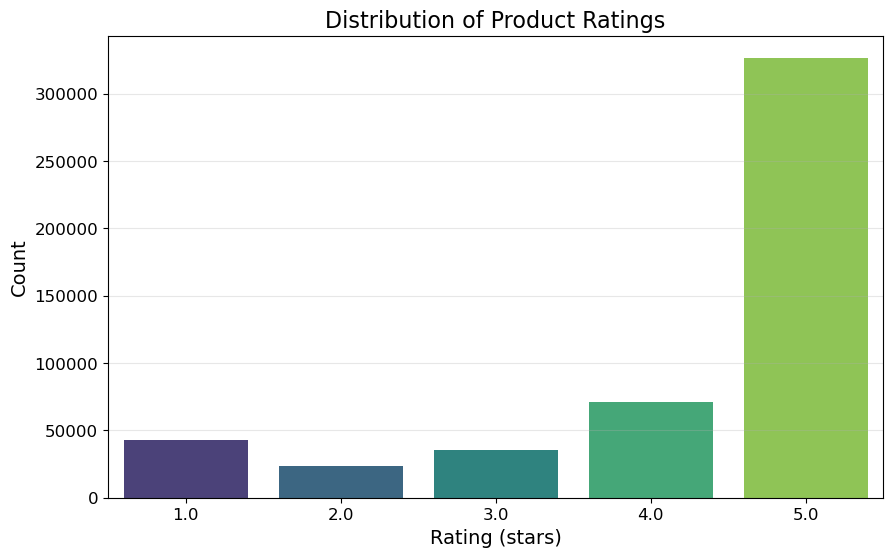

Average product rating: 4.23 stars

Rating distribution (%):
1.0 stars: 8.57%
2.0 stars: 4.70%
3.0 stars: 7.16%
4.0 stars: 14.23%
5.0 stars: 65.34%


In [6]:
# Analyze the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=data, palette='viridis')
plt.title('Distribution of Product Ratings', fontsize=16)
plt.xlabel('Rating (stars)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Calculate average rating
avg_rating = data['rating'].mean()
print(f"Average product rating: {avg_rating:.2f} stars")

# Rating distribution statistics
rating_dist = data['rating'].value_counts(normalize=True) * 100
print("\nRating distribution (%):")
for rating, percentage in sorted(rating_dist.items()):
    print(f"{rating} stars: {percentage:.2f}%")

### 3.2 Review Text Analysis

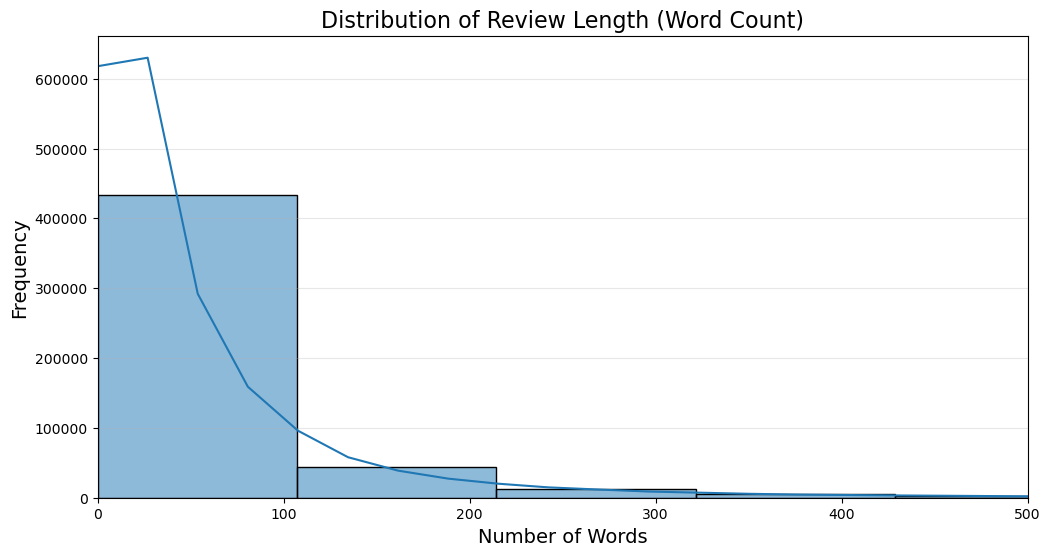

Average review length: 56.64 words
Median review length: 28.00 words
Shortest review: 0 words
Longest review: 5361 words


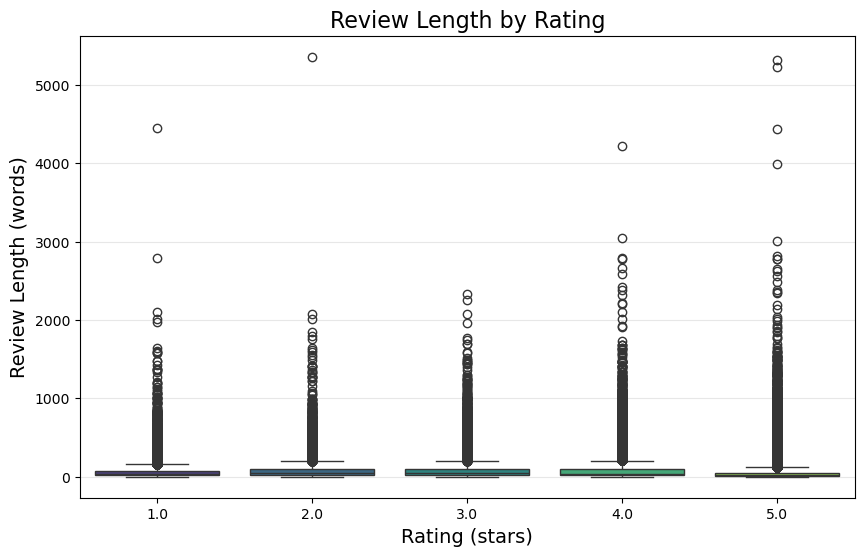

In [7]:
# Analyze review text length
data['review_length'] = data['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='review_length', bins=50, kde=True)
plt.title('Distribution of Review Length (Word Count)', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, 500)  # Limiting x-axis for better visualization
plt.grid(axis='y', alpha=0.3)
plt.show()

# Review length statistics
print(f"Average review length: {data['review_length'].mean():.2f} words")
print(f"Median review length: {data['review_length'].median():.2f} words")
print(f"Shortest review: {data['review_length'].min()} words")
print(f"Longest review: {data['review_length'].max()} words")

# Relationship between review length and rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='review_length', data=data, palette='viridis')
plt.title('Review Length by Rating', fontsize=16)
plt.xlabel('Rating (stars)', fontsize=14)
plt.ylabel('Review Length (words)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 3.2 Temporal Analysis

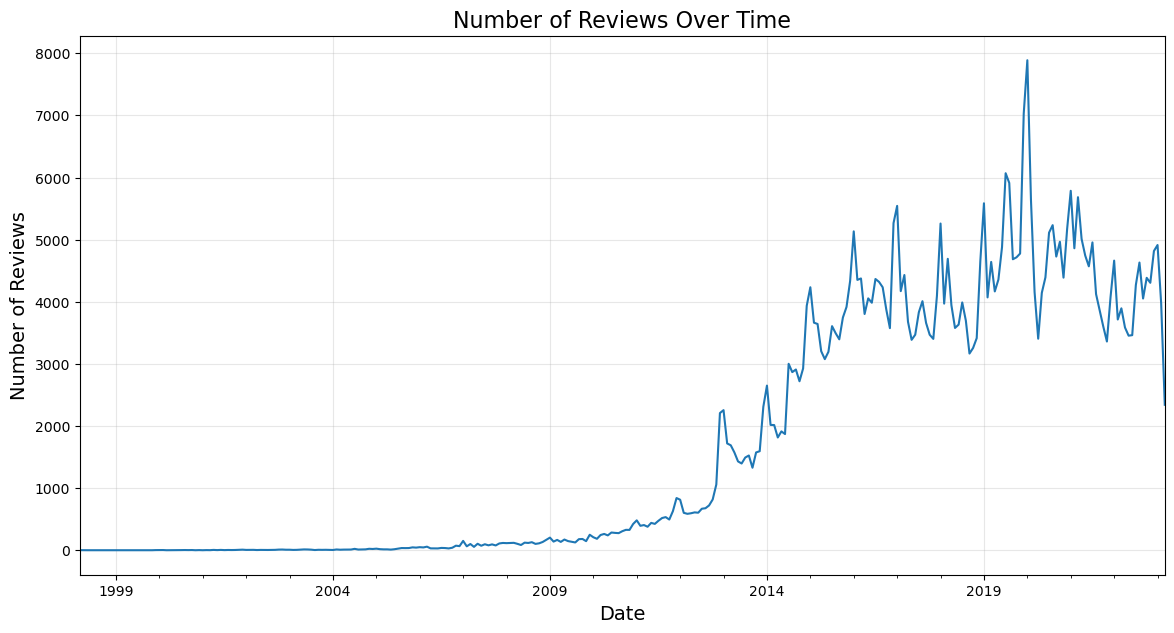

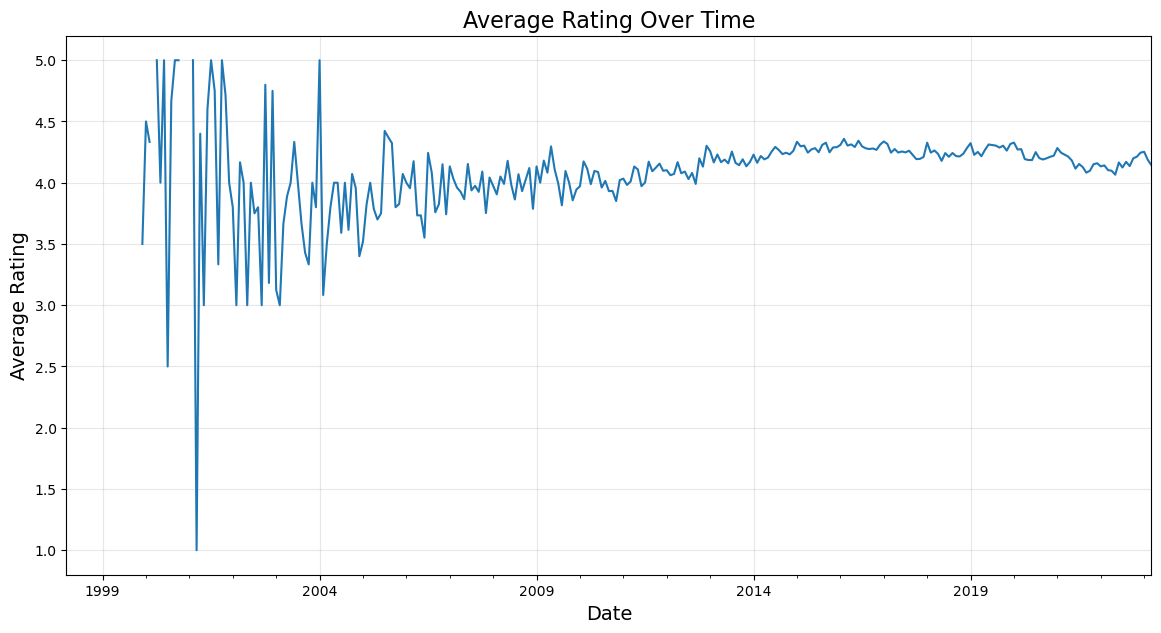

In [8]:
# Convert Unix time to datetime
data['reviewTime'] = pd.to_datetime(data['timestamp'], unit='ms')

# Reviews over time
plt.figure(figsize=(14, 7))
data.set_index('reviewTime').resample('M')['rating'].count().plot()
plt.title('Number of Reviews Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

# Average rating over time
plt.figure(figsize=(14, 7))
data.set_index('reviewTime').resample('M')['rating'].mean().plot()
plt.title('Average Rating Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

### 3.4 Product and Reviewer Analysis

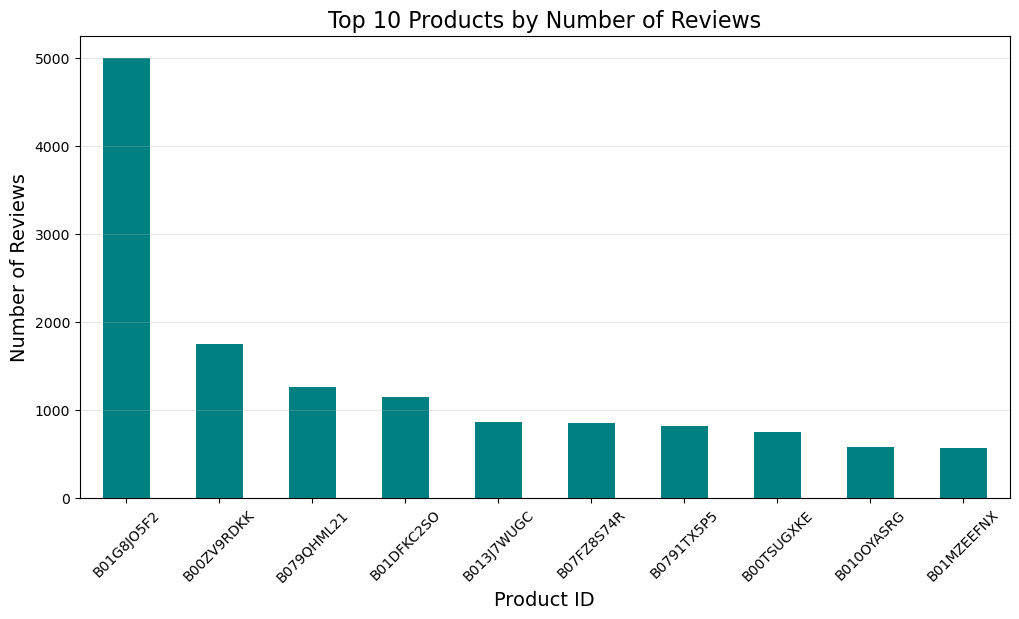

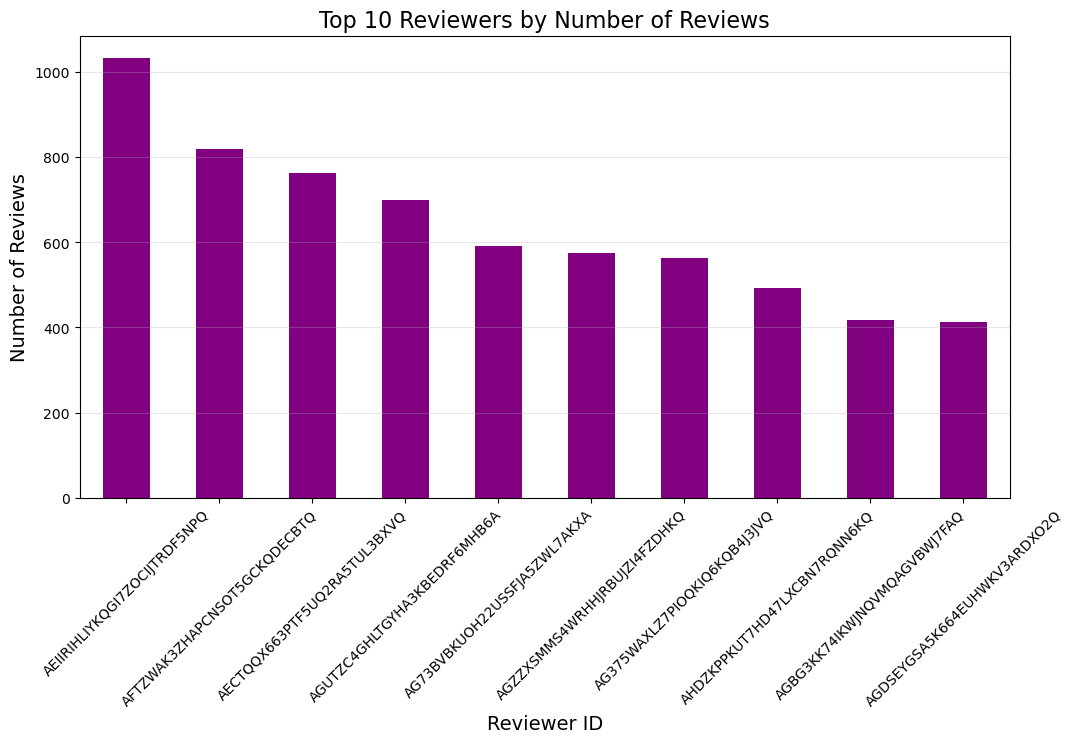

In [9]:
# Top products by number of reviews
top_products = data['asin'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_products.plot(kind='bar', color='teal')
plt.title('Top 10 Products by Number of Reviews', fontsize=16)
plt.xlabel('Product ID', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Top reviewers
top_reviewers = data['user_id'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_reviewers.plot(kind='bar', color='purple')
plt.title('Top 10 Reviewers by Number of Reviews', fontsize=16)
plt.xlabel('Reviewer ID', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 3.5 Helpfulness Analysis

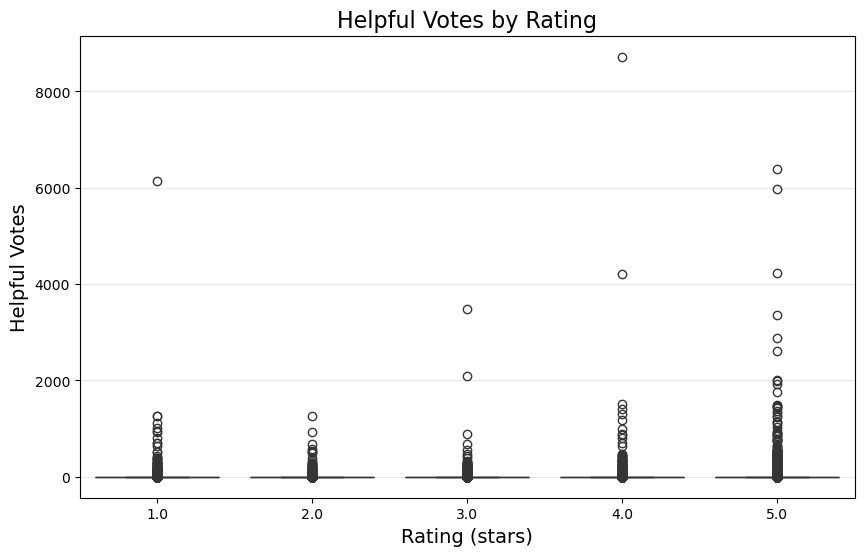

In [10]:
# Relationship between helpfulness and rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='helpful_vote', data=data, palette='viridis')
plt.title('Helpful Votes by Rating', fontsize=16)
plt.xlabel('Rating (stars)', fontsize=14)
plt.ylabel('Helpful Votes', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 3.6 Pre-processing

In [11]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Handle missing values
data['text'] = data['text'].fillna('')
data['title'] = data['title'].fillna('')

# Remove duplicates
original_count = len(data)
data = data.drop_duplicates(subset=['user_id', 'asin', 'text'])
print(f"Removed {original_count - len(data)} duplicate reviews")

# Filter out reviews with no text
data = data[data['text'].str.strip() != '']
print(f"Dataset size after cleaning: {data.shape[0]} reviews")

Missing values in each column:
rating                0
title                85
text                 85
images                0
asin                  0
parent_asin           0
user_id               0
timestamp             0
helpful_vote          0
verified_purchase     0
review_length         0
reviewTime            0
dtype: int64
Removed 990 duplicate reviews
Dataset size after cleaning: 498819 reviews


In [18]:
# Text preprocessing function
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Apply preprocessing to review text
print("Preprocessing review text...")
data['processed_text'] = data['text'].apply(preprocess_text)
print("Text preprocessing complete")

# Display a sample of original and processed text
sample_idx = np.random.randint(0, len(data))
print("\nOriginal text:")
print(data.iloc[sample_idx]['text'])
print("\nProcessed text:")
print(data.iloc[sample_idx]['processed_text'])

[nltk_data] Downloading package stopwords to /Users/alec/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/alec/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/alec/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Preprocessing review text...
Text preprocessing complete

Original text:
[[VIDEOID:dd50dbaf25424bde95d854e219cc88b]] I am purchasing a second one. I was searching for a different one but nothing similar out there. I love this one because it’s soft on the bottom, it adjust to multiple levels, it is lightweight, and you can set it up anyway you sit on the couch or bed or car. Nothing else out there that compares.

Processed text:
videoiddddbafbdedeccb purchasing second one searching different one nothing similar love one soft bottom adjust multiple level lightweight set anyway sit couch bed car nothing else compare


## 4. Unsupervised Learning: Topic Modeling with NLP

In this section, I will apply topic modeling techniques to discover latentthemes in the product reviews. Topic modeling is an unsupervised machine learning technique that can identify hidden topics in a collection of documents.

I'll implement and compare two popular topic modeling approaches:
1. Non-Negative Matrix Factorization (NMF)
2. K-Means Clustering

These methods will help me understand what customers are discussing in their reviews without the need for labeled data.

### 4.1 Feature Extraction

In [19]:
# Feature extraction using TF-IDF
print("Extracting features using TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, 
                                    min_df=5, 
                                    max_df=0.8,
                                    stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data['processed_text'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

Extracting features using TF-IDF...
TF-IDF matrix shape: (498819, 5000)


In [22]:
# Get feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

For the next two sections, I apply some techniques to a subset to my subset of data. My goal is to uncover patterns in customer feedback without relying on labeled outcomes like star ratings during the modeling process.

- TF-IDF vectorization converts review text into numerical feature representations.
- NMF (Non-negative Matrix Factorization) is used to extract interpretable topics from the reviews.
- K-Means clustering groups similar reviews together based on their word usage patterns.

I then compare the resulting clusters to average ratings to assess the nature of each cluster — giving some post-hoc interpretability.

### 4.2 Non-Negative Matrix Factorization (NMF)

I applied NMF to the TF-IDF matrix to identify common themes in the reviews. Each topic consists of a set of high-weight words, representing distinct ideas or sentiments frequently expressed by users.

In [23]:
from sklearn.decomposition import NMF

# Apply NMF
print("Applying NMF for topic modeling...")
n_topics = 10 
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# Function to display topics
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")

# Display the topics
print("Top 10 words for each topic:")
display_topics(nmf_model, tfidf_feature_names)

Applying NMF for topic modeling...
Top 10 words for each topic:
Topic 1:
great price value worked buy look item deal fit fast


Topic 2:
good price far value quality look deal pretty buy money


Topic 3:
work fine expected perfectly advertised didnt described doesnt issue problem


Topic 4:
like cable time battery camera really dont need use bought


Topic 5:
love color daughter case gift son bought absolutely husband kindle


Topic 6:
product excellent described recommend awesome advertised happy fast exactly expected


Topic 7:
perfect fit perfectly needed size case ipad need laptop exactly


Topic 8:
easy use install set setup super simple picture light recommend


Topic 9:
sound quality price speaker excellent headphone ear comfortable better music


Topic 10:
nice case fit look ipad price color cover sturdy really




### 4.2 K-Means Clustering

I clustered the TF-IDF vectors using MiniBatchKMeans and assigned each review to one of 5 clusters. Although K-Means was applied without access to star ratings, I found that the clusters differed somewhat differently in their clusters.

Applying K-Means clustering...

Cluster sizes:
kmeans_cluster
1    381875
4     50236
0     32827
3     19328
2     14553
Name: count, dtype: int64

Top terms in cluster 0:
           term          rank
1878      great  12422.029101
4917       work   8922.675165
3312    product   2404.304721
3282      price   1504.937488
1347       easy    586.650209
3386    quality    583.867607
1496   expected    568.328610
4721      value    561.602328
2532       love    503.910798
3100  perfectly    484.637851


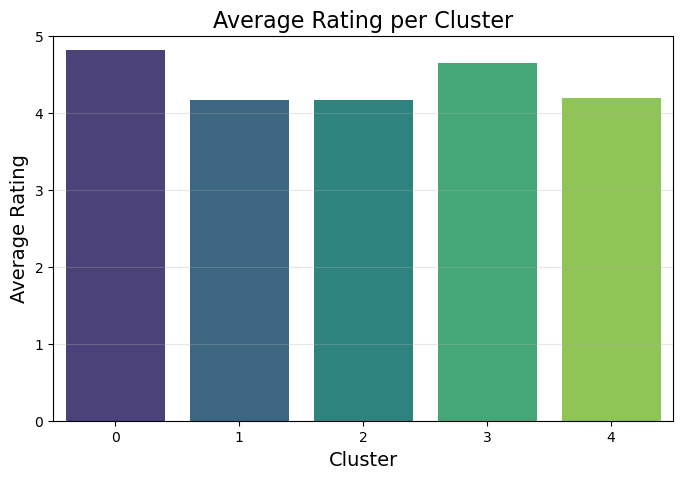

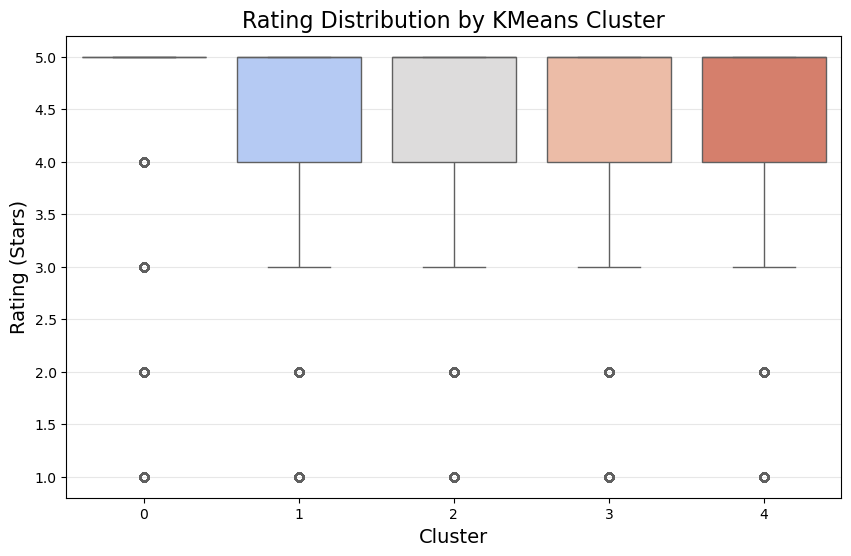

In [24]:
from sklearn.cluster import MiniBatchKMeans

# Apply K-Means
print("Applying K-Means clustering...")

kmeans_model = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=1000)
kmeans_clusters = kmeans_model.fit_predict(tfidf_matrix)

# Add cluster labels to the dataframe
data['kmeans_cluster'] = kmeans_clusters

# Analyze cluster characteristics
print("\nCluster sizes:")
print(data['kmeans_cluster'].value_counts())

# Display top terms per cluster (example for cluster 0)
cluster_0_positions = np.where(data['kmeans_cluster'] == 0)[0]
cluster_0_tfidf = tfidf_matrix[cluster_0_positions]
print("\nTop terms in cluster 0:")
sums = cluster_0_tfidf.sum(axis=0)
data_cluster_0 = []
for col, term in enumerate(tfidf_feature_names):
    data_cluster_0.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data_cluster_0, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False).head(10))

avg_rating = data.groupby('kmeans_cluster')['rating'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_rating, x='kmeans_cluster', y='rating', palette='viridis')
plt.title('Average Rating per Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.ylim(0, 5)
plt.grid(axis='y', alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='kmeans_cluster', y='rating', palette='coolwarm')
plt.title('Rating Distribution by KMeans Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Rating (Stars)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.show()

## 5. Evaluation and Analysis

### 5.1 Topic Modeling Results

After applying NMF to the TF-IDF matrix, I extracted 10 distinct topics. The top words for each topic allowed me to come up with tentative labels for a future use:

| Topic | Top Words                                     | Suggested Label            |   |   |
|-------|-----------------------------------------------|----------------------------|---|---|
| 1     | great, price, value, worked, buy              | Affordability & Quick Use  |   |   |
| 2     | good, price, value, quality                   | Good Value Products        |   |   |
| 3     | work, fine, expected, advertised, problem     | Works As Expected / Issues |   |   |
| 4     | cable, battery, camera, need, use             | Accessories & Battery Life |   |   |
| 5     | love, color, daughter, gift, husband          | Gifts & Personal Use       |   |   |
| 6     | product, excellent, recommend, awesome, happy | High Satisfaction Reviews  |   |   |
| 7     | perfect, fit, size, laptop, ipad              | Fit and Size Issues        |   |   |
| 8     | easy, use, install, setup, simple             | Ease of Use & Setup        |   |   |
| 9     | sound, quality, speaker, headphone, music     | Audio Quality              |   |   |
| 10    | nice, case, ipad, sturdy, color               | Device Protection (Cases)  |   |   |

### 5.2 Clustering Results

From K-Means clustering (k=5):

| Cluster | Size    | Average Rating | Top Themes                              |
|---------|---------|----------------|-----------------------------------------|
| 0       | 32,827  | ~4.8 stars     | Positive: great, work, price, easy      |
| 1       | 381,875 | ~4.2 stars     | Large mixed cluster (general reviews)   |
| 2       | 14,553  | ~4.2 stars     | Smaller, possibly niche (fewer reviews) |
| 3       | 19,328  | ~4.5 stars     | Strong positive cluster                 |
| 4       | 50,236  | ~4.2 stars     | Mixed-to-positive                       |

Key Points:

- Cluster 0: Highly positive reviews — keywords like "great," "work," "easy," "value" suggest strong satisfaction.
- Cluster 1: General large cluster with average reviews, some mixed feedback.
- Cluster 3: Another relatively high satisfaction group (~4.5).
- Clusters 2 and 4: Mid-level satisfaction.

The boxplot shows that while all clusters have some lower outlier ratings, the median ratings remain high, typical for Amazon electronics (which tend to be positively skewed).

### Conclusion & Discussion

In this project, I used unsupervised learning techniques to look at patterns in a subset of Amazon electronics reviews. I used topic modeling with NMF to identify themes that customers frequently discussed, such as affordability, product reliability, ease of use, and audio quality. K-Means clustering then grouped reviews with similar content, showing that these clusters often aligned with differences in customer satisfaction levels — even though no rating information was used during training. This shows that unsupervised learning can uncover meaningful structure in customer feedback without the need for labeled data.

The models proved to be valuable for understanding large volumes of unstructured text. NMF produced interpretable topics that matched real-world product features, while clustering grouped reviews in ways that reflected sentiment trends. These methods offer a scalable approach for businesses to explore important customer concerns, highlight product strengths, and identify opportunities for improvement based purely on natural review content.

There is definitley room to refine these models further. Incorporating more advanced clustering algorithms or dimensionality reduction techniques could reveal even more structures in the data. Connecting discovered topics more directly to specific products or adding sentiment scoring could also improve my results here. Overall, this project demonstrates the strong potential of unsupervised learning to make sense of complex textual data and guide data-driven decision making.